In [6]:
import numpy as np
from numpy.core.fromnumeric import argmax
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib import cm


In [7]:
import os
import json

datapath = "../"
datafiles = [os.path.join(datapath, f) for f in os.listdir(datapath) if os.path.isfile(os.path.join(datapath, f)) and f.endswith(".json")]

parameters = []
for datafile in datafiles:
    with open(datafile) as f:
        jsondata = json.load(f)
        parameters.append(jsondata)


Ts = []
Ls = []
stds = []
covs = []

def covariance(x: np.array):
    dx = x - np.mean(x)
    tmax = x.shape[1]//2
    cor = np.zeros((x.shape[0], tmax))
    for t in range(tmax):
        cor[:, t] = np.mean(dx * np.roll(dx, t, axis=1), axis=1)
    return cor

for parameter_set in parameters:
    T = parameter_set["timespan"]
    L = parameter_set["length"]
    if T > 200:
        Ls.append(L)
        Ts.append(T)
        datafile = datapath + parameter_set["name"] + ".csv"
        lengths = np.loadtxt(datafile, delimiter=',', dtype=int, usecols=range(0, T))
        stds.append(np.std(lengths, axis=1))
        covs.append(covariance(lengths))

# The amount of simulation data
M = len(Ls)


In [8]:
def autocorrelation(t: int, x: np.array):
    dx = (x - np.mean(x))
    if t == 0:
        return 1.0
    elif t >= len(x):
        return 0.0
    autocov = np.sum(dx[:-t]*dx[t:])
    return autocov/np.sum((dx*dx))

def correlation_profile(x: np.array):
    ts = np.arange(len(x) // 2)
    return np.vectorize(lambda t: autocorrelation(t, x))(ts)

def correlation_time(x: np.array):
    return np.argmax(correlation_profile(x) < np.exp(-1))

tcors = np.zeros(M)
for i, std in enumerate(stds):
    tcors[i] = correlation_time(std)
    print("T: {}, L: {}, tcor: {}".format(Ts[i], Ls[i], tcors[i]))



T: 900, L: 45, tcor: 4.0
T: 400, L: 20, tcor: 3.0
T: 500, L: 25, tcor: 4.0
T: 600, L: 30, tcor: 4.0
T: 1000, L: 50, tcor: 4.0
T: 300, L: 15, tcor: 3.0
T: 800, L: 40, tcor: 6.0
T: 700, L: 35, tcor: 7.0


In [9]:
batch_count = 10 # Choose such that the batches themselves are larger than tcor
std = np.zeros(M)
std_err = np.zeros(M)
cov = [None] * M
cov_err = [None] * M

for i in range(M):
    std_batched = np.mean(np.array_split(stds[i], batch_count), axis=1)
    if correlation_time(std_batched) > 1:
        print("The batches of L: {}, T: {} are not independent!")
    cov_batched = np.mean(np.array_split(covs[i], 10), axis=0)

    std[i] = np.mean(std_batched)
    std_err[i] = np.std(std_batched) / np.sqrt(batch_count - 1)
    cov[i] = np.mean(cov_batched, axis=0)
    cov_err[i] = np.std(cov_batched, axis=0) / np.sqrt(batch_count - 1)


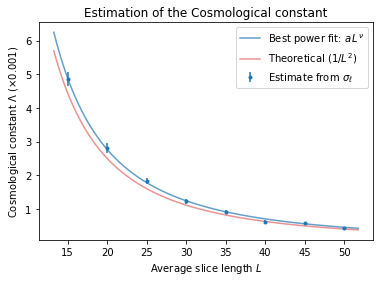

In [10]:
Lambda = 0.5/std**2
Lambda_err = std_err/std**3
plt.errorbar(Ls, Lambda, yerr=Lambda_err, fmt='.', label="Estimate from $\sigma_\ell$", color="tab:blue")

# Fit
extra = 0.05*(max(Ls) - min(Ls))
L = np.linspace(min(Ls) - extra, max(Ls) + extra, 100)
fit = opt.curve_fit(lambda L, a, nu: a/L**nu, Ls, Lambda)
plt.plot(L, fit[0][0] / L**fit[0][1], alpha=0.7, color="tab:blue", label=r"Best power fit: $a\,L^\nu$")
# Theoretical
plt.plot(L, 1/L**2, color='tab:red', label='Theoretical ($1/L^2$)', alpha=0.5)

# Plot settings
plt.xlabel('Average slice length $L$')
plt.ylabel(r'Cosmological constant $\Lambda$ ($\times 0.001$)')
plt.yticks(ticks=np.linspace(1e-3, 6e-3, 6), labels=np.arange(1, 6+1))
plt.legend()
plt.title("Estimation of the Cosmological constant")
# plt.savefig("Lambda_estimate.pdf", bbox_inches='tight')
plt.show()


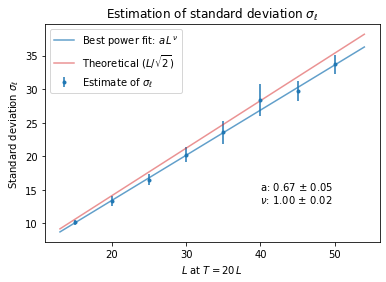

    measured     | theoretical
a : 0.672 +- 0.047 | 0.71
nu: 1.000 +- 0.021 | 1.00


In [11]:
def std_fit(L, a, nu):
    return a*L**nu

fit = opt.curve_fit(std_fit, Ls, std, sigma=std_err, absolute_sigma=True)
error_size = 2 # amount of sigma's displayed as error

# Std with fit
plt.errorbar(Ls, std, yerr=error_size*std_err, fmt='.', color="tab:blue", label="Estimate of $\sigma_\ell$")
L = np.linspace(13, 54, 100)
plt.plot(L, std_fit(L, *fit[0]), alpha=0.7, label=r'Best power fit: $a\,L^\nu$', color="tab:blue")
plt.text(40, 15, r"a: {:.2f} $\pm$ {:.1}".format(fit[0][0], np.sqrt(fit[1][0, 0])))
plt.text(40, 13, r"$\nu$: {:.2f} $\pm$ {:.1}".format(fit[0][1], np.sqrt(fit[1][1, 1])))
# Theoretical
plt.plot(L, L/np.sqrt(2), alpha=0.5, color="tab:red", label="Theoretical ($L/\sqrt{2}$)")

# Plot settings
plt.xlabel("$L$ at $T = 20\,L$")
plt.ylabel("Standard deviation $\sigma_\ell$")
plt.legend()
plt.title("Estimation of standard deviation $\sigma_\ell$")
# plt.savefig("std_estimate.pdf", bbox_inches='tight')
plt.show()

# Print found parameters
print("    measured     | theoretical")
print("a : {:.3f} +- {:.2} | {:.2}".format(fit[0][0], np.sqrt(fit[1][0, 0]), np.sqrt(0.5)))
print("nu: {:.3f} +- {:.2} | {:.2f}".format(fit[0][1], np.sqrt(fit[1][1, 1]), 1.00))


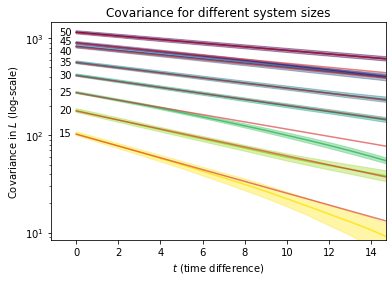

In [12]:
# # Linear scale
# textextra = 5 
# textpush = np.zeros(M)
# log scale
textextra = 0.5
textpush = 60*(.5*(np.array(Ls) == 45) - 1.5*(np.array(Ls) == 40))

colors = cm.viridis(np.linspace(1.0, 0.0, M))
seq = next(zip(*sorted(zip(np.arange(M), Ls), key=lambda x: x[1])))

error_size = 2 # amount of sigma's displayed as error
for ci, i in enumerate(seq):
    t = np.arange(Ts[i] // 2)
    plt.plot(t, cov[i], label="L = {}, T = {}".format(Ls[i], Ts[i]), color=colors[ci])
    plt.fill_between(t, cov[i] - error_size*cov_err[i], cov[i] + error_size*cov_err[i], alpha=0.4, color=colors[ci])
    plt.plot(t, 0.5*np.exp(-2*t*np.sqrt(Lambda[i]))/Lambda[i], color="tab:red", alpha=0.6)
    plt.text(-textextra, cov[i][0]+textpush[i], "{:}".format(Ls[i]), va='center', ha='center')

# ## Linear scale
# xrange = (0, 140)
# xextra = 0.05*(xrange[1] - xrange[0])
# plt.xlim(xrange[0] - xextra - textextra, xrange[1] + xextra)
# yrange = (np.min([np.min(c[xrange[0]:xrange[1]]) for c in cov]), np.max(cov[np.argmax(Ls)]))
# yextra = 0.05*(yrange[1] - yrange[0])
# plt.ylim(yrange[0]-yextra, yrange[1]+yextra)
# plt.legend()
# plt.yticks(np.linspace(0, 1200, 7), ["{:.1f}".format(l) for l in np.linspace(0.0, 1.2, 7)])
# plt.ylabel(r"Covariance in $L$ ($\times 1000$)")

## First part log scale
xrange = (0, 14)
xextra = 0.05*(xrange[1] - xrange[0])
plt.xlim(xrange[0] - xextra - textextra, xrange[1] + xextra)
plt.yscale('log')
yrange = (cov[np.argmin(Ls)][xrange[1]], cov[np.argmax(Ls)][xrange[0]])
yextra = 0.05*(np.log10(yrange[1]) - np.log10(yrange[0]))
plt.ylim(10**(np.log10(yrange[0]) - yextra), 10**(np.log10(yrange[1]) + yextra))
plt.ylabel("Covariance in $L$ (log-scale)")

 
plt.xlabel("$t$ (time difference)")
plt.title("Covariance for different system sizes")

# plt.savefig("cov_L_log.pdf", bbox_inches='tight')
plt.show()


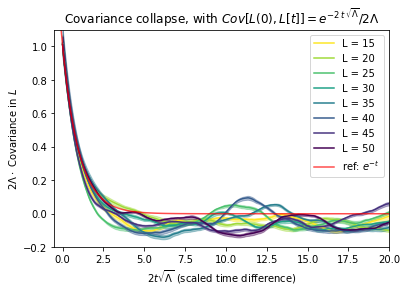

In [13]:
colors = cm.viridis(np.linspace(1.0, 0.0, M))
seq = next(zip(*sorted(zip(np.arange(M), Ls), key=lambda x: x[1])))

error_size = 1 # amount of sigma's displayed as error
for ci, i in enumerate(seq):
    t = np.arange(Ts[i] // 2)
    cov_scaled = cov[i] * (2*Lambda[i])
    t_scaled = t * (2*np.sqrt(Lambda[i]))
    err_scaled = 2*np.sqrt((cov_err[i]*Lambda[i])**2 + (cov[i]*Lambda_err[i])**2)
    plt.plot(t_scaled, cov_scaled, label="L = {}".format(Ls[i]), color=colors[ci])
    plt.fill_between(t_scaled, cov_scaled - error_size*err_scaled, cov_scaled + error_size*err_scaled, alpha=0.4, color=colors[ci])
t = np.linspace(-1, 20.0, 100)
plt.plot(t, np.exp(-t), color='r', alpha=0.7, label=r'ref: $e^{-t}$')

## Linear scale
plt.xlim(-0.5, 20.0)
plt.ylim(-0.2, 1.1)
# ## First part log scale
# plt.xlim(-0.1, 1.8)
# plt.yscale('log')
# plt.yticks([1., 0.1])
# plt.ylim(0.03, 1.5)

plt.legend()

plt.xlabel("$2 t \sqrt{\Lambda}$ (scaled time difference)")
plt.ylabel("$2 \Lambda \cdot$ Covariance in $L$")
plt.title(r"Covariance collapse, with $Cov[L(0), L[t]] = e^{- 2 \,t \,\sqrt{\Lambda}} / 2\Lambda$")
# plt.savefig("cov_collapsed.pdf", bbox_inches='tight')
plt.show()